#TRABALHO FINAL - GRUPO 03
1. Disciplina: Data Analytics Hand's On
2. Integrantes:

*   Leandro Ariel Caputo
*   Matheus Oliveira
*   Loyanne Cristina Lemos Rabelo
*   Victor Miranda Bulhosa


##APRESENTAÇÃO DOS DADOS E OBJETIVO DO TRABALHO

Link para a base de dados: https://www.kaggle.com/ashwinik/consumer-complaints-financial-products

Aplicação de Classificação de Texto : Reclamações de Clientes Sobre Produtos e Serviços de Instituições Financeiras nos EUA

---

Contexto

Esta base de dados contém uma coleção de reclamações de clientes sobre produtos e serviços financeiros que são enviados para resposta de bancos e outras instituições. As reclamações são publicadas após a resposta por parte da instituição, confirmando a relação comercial com o cliente, ou após 15 dias, o que ocorrer primeiro.

Objetivo

Selecionar uma classe de produto e seus respectivos problemas associados e com base na narrativa do cliente gerar um modelo de classificação de texto para predição da classe do problema relatado de acordo com a narrativa escrita pelo cliente.



# Bibliotecas Utilizadas Neste Notebook

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
import pickle

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import textwrap

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from pprint import pprint

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

In [ ]:
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')
print("------------------------------------------------------------")
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
------------------------------------------------------------
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
------------------------------------------------------------
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# 1 - Tratamento Inicial da Base

In [ ]:
df_raw = pd.read_csv('Consumer_Complaints.csv',sep=',')

In [ ]:
df_raw.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/29/2013,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,NaN,NaN,Wells Fargo & Company,VA,24540,NaN,NaN,Phone,07/30/2013,Closed with explanation,Yes,No,468882
1,07/29/2013,Bank account or service,Checking account,Using a debit or ATM card,NaN,NaN,NaN,Wells Fargo & Company,CA,95992,Older American,NaN,Web,07/31/2013,Closed with explanation,Yes,No,468889
2,07/29/2013,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,Santander Bank US,NY,10065,NaN,NaN,Fax,07/31/2013,Closed,Yes,No,468879


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670598 entries, 0 to 670597
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 670598 non-null  object
 1   Product                       670598 non-null  object
 2   Sub-product                   472396 non-null  object
 3   Issue                         670598 non-null  object
 4   Sub-issue                     269868 non-null  object
 5   Consumer complaint narrative  114704 non-null  object
 6   Company public response       145197 non-null  object
 7   Company                       670598 non-null  object
 8   State                         665293 non-null  object
 9   ZIP code                      665274 non-null  object
 10  Tags                          94730 non-null   object
 11  Consumer consent provided?    208151 non-null  object
 12  Submitted via                 670598 non-null  object
 13 

A base 'Consumer_Complaints.csv' possui aproximadamente 250 MB em disco com dados sobre reclamações de clientes contra instituições financeiras nos EUA. Ao todo são 18 atributos, sendo que aqueles de interesse inicial para o presente trabalho são:

*   Product: produto ou serviço ao qual a reclamação do cliente se refere.
*   Sub-product: detalhamento do produto ou serviço.
*   Issue: tipo de problema ao qual a reclamação do cliente se refere.
*   Sub-issue: detalhamento do tipo de problema.
*   Consumer complaint narrative: texto em linguagem natural contendo a narrativa do problema escrita pelo cliente.

Como o objetivo do trabalho será gerar um modelo de classificação de texto para predição do tipo do problema a partir da narrativa escrita pelo cliente, não faz sentido deixar na base instâncias onde o atributo 'Consumer complaint narrative' seja nulo. Então será executada uma limpeza inicial dos dados excluindo essas instâncias e também os atributos que não sejam os 5 listados acima.

Dessa forma das 670598 instâncias iniciais, a base será reduzida para 114704 instâncias onde o atributo 'Consumer complaint narrative' não é nulo.

In [ ]:
# ELIMINAR INSTÂNCIAS EM QUE A NARRATIVA (TEXTO) DO CONSUMIDOR SEJA NULA
df_raw = df_raw[df_raw['Consumer complaint narrative'].isna()==False]
df_raw.reset_index(drop=True,inplace=True)
# df_raw.to_csv('Consumer_Complaints2.csv',sep=',')

#DEIXANDO SOMENTE OS ATRIBUTOS DE INTERESSE PARA A CLASSIFICAÇÃO DE TEXTO
df_raw = df_raw[['Product','Sub-product','Issue','Sub-issue','Consumer complaint narrative']]
df_raw.columns = ['produto','subproduto','problema','subproblema','narrativa']
# df_raw.to_csv('reclamacoes.csv',sep=',')

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114704 entries, 0 to 114703
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   produto      114704 non-null  object
 1   subproduto   78920 non-null   object
 2   problema     114704 non-null  object
 3   subproblema  57256 non-null   object
 4   narrativa    114704 non-null  object
dtypes: object(5)
memory usage: 4.4+ MB


In [ ]:
df_raw.head(3)

,produto,subproduto,problema,subproblema,narrativa
0,Credit card,NaN,Other,NaN,Received Capital One charge card offer XXXX. A...
1,Debt collection,"Other (i.e. phone, health club, etc.)",Improper contact or sharing of info,Contacted me after I asked not to,I do n't know how they got my cell number. I t...
2,Credit card,NaN,Rewards,NaN,I 'm a longtime member of Charter One Bank/RBS...


O número de classes de produtos e classes de problemas existentes na base estão listados abaixo, bem como a quantidade de instâncias para cada classe de produto e suas respectivas descrições.

In [ ]:
print(f'Número de classes de produto: {df_raw.produto.nunique()}')
print(f'Número de classes de subproduto: {df_raw.subproduto.nunique()}')
print(f'Número de classes de problema: {df_raw.problema.nunique()}')
print(f'Número de classes de subproblema: {df_raw.subproblema.nunique()}')

Número de classes de produto: 12
Número de classes de subproduto: 46
Número de classes de problema: 90
Número de classes de subproblema: 64


In [ ]:
df_raw.produto.value_counts()

Debt collection            28861
Mortgage                   24641
Credit reporting           22202
Credit card                13582
Bank account or service    10425
Consumer Loan               6394
Student loan                4948
Payday loan                 1245
Prepaid card                1144
Money transfers             1074
Other financial service      176
Virtual currency              12
Name: produto, dtype: int64

Abaixo faremos um análise da distribuição das classes de problema relatados pelos clientes de acordo com o tipo de produto ou serviço.

In [ ]:
df_raw[df_raw.produto=='Debt collection'].problema.value_counts(normalize=True)*100

Cont'd attempts collect debt not owed    42.607671
Disclosure verification of debt          17.878798
Communication tactics                    15.141540
False statements or representation        9.327466
Taking/threatening an illegal action      7.653927
Improper contact or sharing of info       7.390596
Name: problema, dtype: float64

In [ ]:
df_raw[df_raw.produto=='Mortgage'].problema.value_counts(normalize=True)*100

Loan servicing, payments, escrow account    44.413782
Loan modification,collection,foreclosure    33.894728
Application, originator, mortgage broker    11.001989
Settlement process and costs                 6.765148
Credit decision / Underwriting               3.924354
Name: problema, dtype: float64

In [ ]:
df_raw[df_raw.produto=='Credit reporting'].problema.value_counts(normalize=True)*100

Incorrect information on credit report      66.489505
Credit reporting company's investigation    17.565985
Unable to get credit report/credit score     7.801099
Improper use of my credit report             4.954509
Credit monitoring or identity protection     3.188902
Name: problema, dtype: float64

In [ ]:
df_raw[df_raw.produto=='Credit card'].problema.value_counts(normalize=True)*100

Billing disputes                            15.778236
Other                                       10.447651
Identity theft / Fraud / Embezzlement        9.350611
Closing/Cancelling account                   7.686644
Customer service / Customer relations        5.190694
Rewards                                      4.734207
Advertising and marketing                    4.675306
Delinquent account                           4.572228
APR or interest rate                         4.388161
Late fee                                     4.285083
Credit card protection / Debt protection     3.460462
Billing statement                            3.445737
Transaction issue                            3.239582
Credit determination                         2.819909
Payoff process                               2.812546
Other fee                                    2.738919
Credit line increase/decrease                2.378148
Unsolicited issuance of credit card          2.370785
Balance transfer            

In [ ]:
df_raw[df_raw.produto=='Bank account or service'].problema.value_counts(normalize=True)*100

Account opening, closing, or management     43.059952
Deposits and withdrawals                    22.868106
Problems caused by my funds being low       14.685851
Using a debit or ATM card                   10.292566
Making/receiving payments, sending money     9.093525
Name: problema, dtype: float64

In [ ]:
df_raw[df_raw.produto=='Consumer Loan'].problema.value_counts(normalize=True)*100

Managing the loan or lease                  46.168283
Problems when you are unable to pay         26.634345
Taking out the loan or lease                16.499844
Shopping for a loan or lease                 7.757272
Charged fees or interest I didn't expect     1.188614
Lender repossessed or sold the vehicle       0.312793
Payment to acct not credited                 0.281514
Can't contact lender                         0.265874
Managing the line of credit                  0.203316
Account terms and changes                    0.187676
Applied for loan/did not receive money       0.140757
Shopping for a line of credit                0.125117
Received a loan I didn't apply for           0.093838
Can't stop charges to bank account           0.062559
Lender sold the property                     0.046919
Lender damaged or destroyed vehicle          0.015640
Charged bank acct wrong day or amt           0.015640
Name: problema, dtype: float64

In [ ]:
df_raw[df_raw.produto=='Student loan'].problema.value_counts(normalize=True)*100

Dealing with my lender or servicer    71.523848
Can't repay my loan                   25.929669
Getting a loan                         2.546483
Name: problema, dtype: float64

In [ ]:
df_raw[df_raw.produto=='Payday loan'].problema.value_counts(normalize=True)*100

Charged fees or interest I didn't expect    43.212851
Can't contact lender                        18.875502
Received a loan I didn't apply for          11.244980
Can't stop charges to bank account          10.281124
Payment to acct not credited                 6.666667
Charged bank acct wrong day or amt           5.461847
Applied for loan/did not receive money       4.257028
Name: problema, dtype: float64

In [ ]:
df_raw[df_raw.produto=='Prepaid card'].problema.value_counts(normalize=True)*100

Unauthorized transactions/trans. issues    36.188811
Managing, opening, or closing account      28.321678
Fraud or scam                              20.454545
Adding money                                6.993007
Fees                                        5.506993
Advertising, marketing or disclosures       1.311189
Overdraft, savings or rewards features      1.223776
Name: problema, dtype: float64

In [ ]:
df_raw[df_raw.produto=='Money transfers'].problema.value_counts(normalize=True)*100

Fraud or scam                            34.171322
Other transaction issues                 30.912477
Money was not available when promised    17.411546
Other service issues                      9.031657
Wrong amount charged or received          4.934823
Incorrect/missing disclosures or info     3.538175
Name: problema, dtype: float64

In [ ]:
df_raw[df_raw.produto=='Other financial service'].problema.value_counts(normalize=True)*100

Fraud or scam                          39.204545
Customer service/Customer relations    20.454545
Excessive fees                         14.772727
Unexpected/Other fees                   8.522727
Disclosures                             4.545455
Lost or stolen check                    3.977273
Advertising and marketing               3.977273
Lost or stolen money order              3.409091
Incorrect exchange rate                 1.136364
Name: problema, dtype: float64

In [ ]:
df_raw[df_raw.produto=='Virtual currency'].problema.value_counts(normalize=True)*100

Other service issues                     41.666667
Fraud or scam                            41.666667
Other transaction issues                  8.333333
Money was not available when promised     8.333333
Name: problema, dtype: float64

A partir desta análise prévia da base de dados e devido ao seu tamanho e complexidade tanto em número de instâncias quanto em quantidade de classes existentes e suas combinações, foi decidido adotar uma simplificação no escopo do trabalho. Desta forma, o objetivo será:


*   Para o produto 'Bank account or service' elaborar um modelo de classificação do problema relatado a partir da narrativa em linguagem natural da reclamação do cliente.


A escolha pelo produto 'Bank account or service' é devida a esta possuir um número razoável de instâncias (10425) e 5 classes de problemas significativos.

In [ ]:
df = df_raw.copy()
df = df[df.produto=='Bank account or service']
df.drop(['produto','subproduto','subproblema'],inplace=True,axis=1)
df.reset_index(drop=True,inplace=True)
# df.to_csv('bank_account.csv',sep=',')

# 2 - Análise Exploratória dos Dados

In [ ]:
df = pd.read_csv('bank_account.csv',sep=',')
df.drop('Unnamed: 0',inplace=True,axis=1)

In [ ]:
df.head()

,problema,narrativa
0,Using a debit or ATM card,I 'm no longer an account holder of SunTrust. ...
1,"Account opening, closing, or management","After banking with Citibank for over 3 years, ..."
2,Deposits and withdrawals,On XXXX XXXX I went to the Citizens Bank on XX...
3,"Account opening, closing, or management",The following summarizes my issue with PNC Ban...
4,"Account opening, closing, or management",This is a concern with companies in general. T...


## 2.1. Número de narrativas por classe de problema

As narrativas das reclamações dos clientes para o produto 'Conta e Serviços Bancários' estão distribuidas em 5 classes diferentes, conforme abaixo.

In [ ]:
df.problema.value_counts()

Account opening, closing, or management     4489
Deposits and withdrawals                    2384
Problems caused by my funds being low       1531
Using a debit or ATM card                   1073
Making/receiving payments, sending money     948
Name: problema, dtype: int64

In [ ]:
# CODIFICAÇÃO DOS RÓTULOS DAS CLASSES
classes = {'Account opening, closing, or management':1,
           'Deposits and withdrawals':2,
           'Problems caused by my funds being low':3,
           'Using a debit or ATM card':4,
           'Making/receiving payments, sending money':5}
df['classe'] = df.problema.map(classes)
df['classe'] = df['classe'].astype('int8')
df.head()

,problema,narrativa,classe
0,Using a debit or ATM card,I 'm no longer an account holder of SunTrust. ...,4
1,"Account opening, closing, or management","After banking with Citibank for over 3 years, ...",1
2,Deposits and withdrawals,On XXXX XXXX I went to the Citizens Bank on XX...,2
3,"Account opening, closing, or management",The following summarizes my issue with PNC Ban...,1
4,"Account opening, closing, or management",This is a concern with companies in general. T...,1


In [ ]:
df2 = pd.DataFrame(df.groupby('problema').count()['narrativa']).reset_index()

bars = alt.Chart(df2).mark_bar(size=50).encode(
    x=alt.X('problema'),
    y=alt.Y('PercentOfTotal:Q', axis=alt.Axis(format='.0%', title='% de narrativas')),
    color='problema'
).transform_window(
    TotalArticles='sum(narrativa)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.narrativa / datum.TotalArticles"
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    #dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('PercentOfTotal:Q', format='.1%')
)

(bars + text).interactive().properties(
    height=300,
    width=700,
    title = "% de Narrativas em Cada Classe de Problema",
)

alt.LayerChart(...)

Verifica-se no gráfico acima que a distribuição das classes não está balanceada. A depender do tipo de modelo de classificação a ser utilizado mais a frente, pode ser necessário adotar um método de balanceamento entre essas 5 classes.

## 2.2. Análise sobre o tamanho das narrativas das reclamações dos clientes

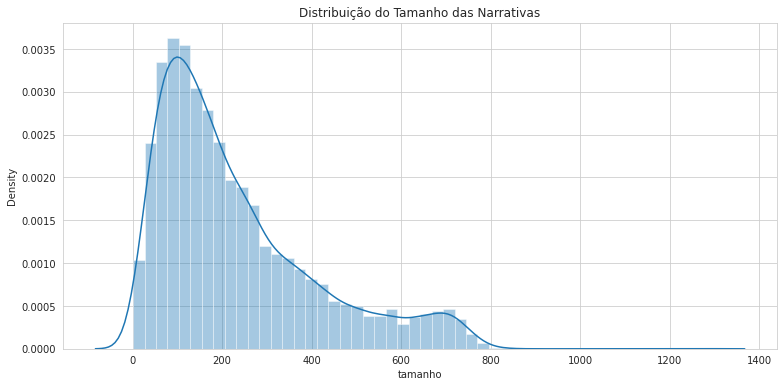

In [ ]:
df['tamanho'] =  [len(palavra.split()) for palavra in df['narrativa']]
plt.figure(figsize=(12.8,6))
sns.distplot(df['tamanho']).set_title('Distribuição do Tamanho das Narrativas');

In [ ]:
df['tamanho'].describe()

count    10425.000000
mean       231.686331
std        178.236603
min          1.000000
25%         99.000000
50%        178.000000
75%        315.000000
max       1284.000000
Name: tamanho, dtype: float64

**Distribuição do tamanho das narrativas por classe**

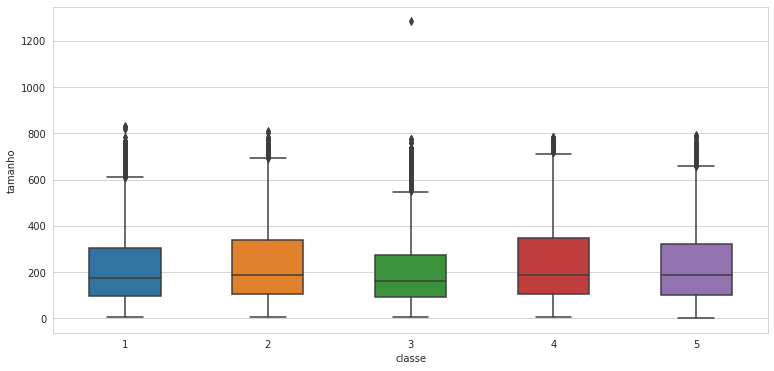

In [ ]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='classe', y='tamanho', width=.5);

De maneira geral, a distribuição do número de palavras por reclamação é parecida entre as classes de problemas, sendo que a classe 1 e a classe 3 são ligeiramente menores.

# 3 - Engenharia de Atributos

## 3.1. Limpeza dos dados - Etapa 01





Nesta primeira etapa da limpeza dos dados vamos apenas remover caracteres especiais e converter o texto para letras minusculas. Não iremos executar remoção de stopwords nem lematização/stemming. O propósito é gerar um modelo baseline para fins de comparação com o modelo final com todos os processamentos realizados.

### 3.1.1. Limpeza de caracteres especiais:

In [ ]:
# Removendo \'s  \r  \n
df['tratado_1'] = df['narrativa'].str.replace("\r", " ")
df['tratado_1'] = df['tratado_1'].str.replace("\'s", "")
df['tratado_1'] = df['tratado_1'].str.replace("\n", " ")
df['tratado_1'] = df['tratado_1'].str.replace("    ", " ")

#Removendo pontuação e números

pontuacao = re.compile(r'[^A-Za-z0-9]+')

# df['tratado_1'] = [pontuacao.sub(" ", content) for content in df['tratado_1']]
# df['tratado_1'] = [content.translate(str.maketrans('','', string.digits)) for content in df['tratado_1']]

df['tratado_1'] = df['tratado_1'].apply(lambda x: pontuacao.sub(" ", x))
df['tratado_1'] = df['tratado_1'].apply(lambda x: x.translate(str.maketrans('','', string.digits)) )

### 3.1.2. Conversão para letras minúsculas

In [ ]:
# convertendo para minúsculo
df['tratado_2'] = df['tratado_1'].str.lower()

### 3.1.3. Nuvem de palavras

In [ ]:
# Faremos um backup do df para poder remover as stopwords sem que isso impacte na baseline que será gerada adiante
df_wordcloud = df[["problema","tratado_2"]].copy()

In [ ]:
# Baixando as listas de stopwords
nltk.download('stopwords')

# Carregando a lista de stopwords em inglês
stop_words = list(stopwords.words('english'))

# Remoção de stopwords
extras = ['xx','xxxx','bank','citigold','wells','fargo','citi','account','credit','debit','card', 'told', 'said', 'check']
stop_words = stop_words + extras

df_wordcloud['tratado_3'] = df_wordcloud['tratado_2']

for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df_wordcloud['tratado_3'] = df_wordcloud['tratado_3'].str.replace(regex_stopword, '')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_wordcloud

,problema,tratado_2,tratado_3
0,Using a debit or ATM card,i m no longer an account holder of suntrust i ...,longer holder suntrust used realize...
1,"Account opening, closing, or management",after banking with citibank for over years i ...,banking citibank years discovered eveni...
2,Deposits and withdrawals,on xxxx xxxx i went to the citizens bank on xx...,went citizens gave son informa...
3,"Account opening, closing, or management",the following summarizes my issue with pnc ban...,following summarizes issue pnc banks policy...
4,"Account opening, closing, or management",this is a concern with companies in general th...,concern companies general retention per...
...,...,...,...
10420,"Account opening, closing, or management",i would like to make a complaint for a securit...,would like make complaint security invest...
10421,"Account opening, closing, or management",three months ago bank of america started charg...,three months ago america started charging ...
10422,"Account opening, closing, or management",my dad passed away on xxxx xxxx he had a chec...,dad passed away checking america ...
10423,"Account opening, closing, or management",i reported this issue before and bank of ameri...,reported issue america enterprise depart...


Nuvem de palavras para problema: Using a debit or ATM card 



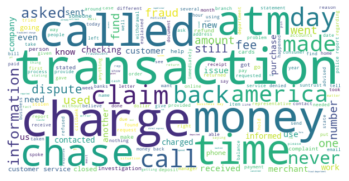



Nuvem de palavras para problema: Account opening, closing, or management 



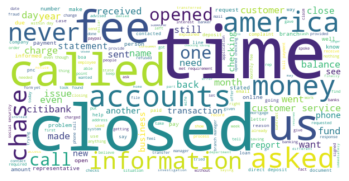



Nuvem de palavras para problema: Deposits and withdrawals 



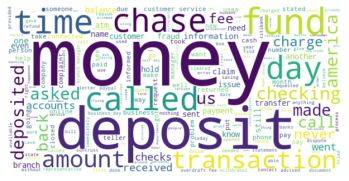



Nuvem de palavras para problema: Making/receiving payments, sending money 



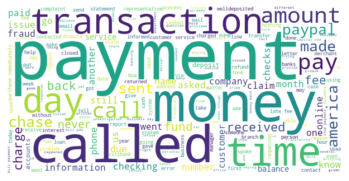



Nuvem de palavras para problema: Problems caused by my funds being low 



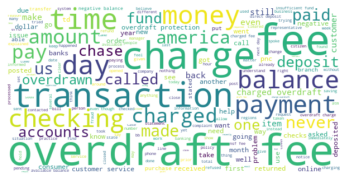

In [ ]:
#!pip install wordcloud
from wordcloud import WordCloud

### Create a unqiue list fo each products
product_list = df_wordcloud['problema'].unique()
### Iterate through each products category
for i in product_list:
    ### Convert the text to lower case and subset only text for product of interest
    text = " ".join(review.lower() for review in df_wordcloud[df_wordcloud['problema'] == i]['tratado_3'])

    # Generate a word cloud image
    wc = WordCloud(background_color="white", width=600, height=300).generate(text)
    # display(pd.DataFrame(text.split()).value_counts())

    # Display the generated image:
    # the matplotlib way:
    print ("Nuvem de palavras para problema:", i, "\n")
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print("\n============================================== \n")

Como podemos observar, as palavras em destaque para os respectivos problemas são:
*  Using a debit or ATM card: transaction, charge, money.
*  Account opening, closing, or management: closed, time, fee.
*  Deposits and withdrawals: money, fund, deposit.
*  Making/receiving payments, sending money: payment, **transaction**, money.
*  Problems caused by my funds being low: fee, overdraft, charge.

Mais adiante, após a criação da nossa baseline, haverá etapas de tratamento de dados para que haja a redução de palavras repetidas por classes, o que pode dificultar a classificação.

Nuvem de palavras geral: 



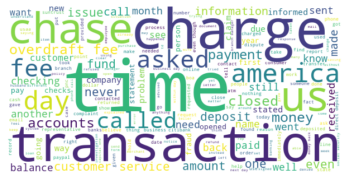

In [ ]:
# Agora uma visão geral (sem separar por problemas):

# Convert the text to lower case and subset only text for product of interest
text = " ".join(review.lower() for review in df_wordcloud['tratado_3'])

# Generate a word cloud image
wc = WordCloud(background_color="white", width=600, height=300).generate(text)
# display(pd.DataFrame(text.split()).value_counts())

# Display the generated image:
# the matplotlib way:
print ("Nuvem de palavras geral: \n")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

No caso geral, sem separação por tipo de problema, as palavras em destaque foram: time, charge e transaction.

## MODELO BASELINE

Iremos inicialmente rodar um modelo baseline com as seguintes premissas:



*   Pré-processamento dos dados: apenas limpeza de caracteres especiais, pontuação e números. Sem remoção de stopwords e sem aplicação de lematização ou stemming.
*   Transformação dos dados: os tokens serão gerados utilizando a classe TfidfVectorizer do sklearn com todas as configurações default.
*   Seleção de atributos: sem seleção de atributos.
*   Algorítmos utilizados: Random Forest, SVM e Multinomial Naive-Bayes. Todos com as configurações default.
*  As métricas utilizadas para fins de comparação serão F1 e acurácia.

In [ ]:
#MODELO BASELINE

## DIVISÃO DOS CONJUNTOS DE TREINAMENTO E TESTE

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(df['tratado_2'],
                                                    df['classe'],
                                                    test_size=0.15,
                                                    random_state=1,
                                                    stratify=df['classe'])

## TRANSFORMAÇÃO DOS DADOS (TOKENS)

tfidf_B = TfidfVectorizer()

features_train_B = tfidf_B.fit_transform(X_train_B).toarray()
labels_train_B = y_train_B
print(features_train_B.shape)

features_test_B = tfidf_B.transform(X_test_B).toarray()
labels_test_B = y_test_B
print(features_test_B.shape)

(8861, 18409)
(1564, 18409)


Com as configurações default e com um pré-processamento mínimo dos dados foram gerados 18409 tokens que serão utilizados no modelo baseline.

O código abaixo ilustra os 10 unigramas mais frequentes gerados para cada uma das cinco classes de problemas relatados nas narrativas dos clientes.

In [ ]:
#MODELO BASELINE

## TESTE CHI2 PARA IDENTIFICAR AS PALAVRAS MAIS CORRELACIONADAS COM CADA CLASSE

for rotulo, codigo in sorted(classes.items()):
    features_chi2_B = chi2(features_train_B, labels_train_B == codigo)
    indices_B = np.argsort(features_chi2_B[0])
    feature_names_B = np.array(tfidf_B.get_feature_names())[indices_B]
    unigrams_B = [v for v in feature_names_B if len(v.split(' ')) == 1]
    print("# CLASSE: '{}':".format(rotulo))
    print(" . Unigramas mais correlacionados:\n. {}".format('\n. '.join(unigrams_B[-10:])))
    print("")

# CLASSE: 'Account opening, closing, or management':
 . Unigramas mais correlacionados:
. met
. citigold
. offer
. overdraft
. points
. requirements
. citi
. miles
. bonus
. promotion

# CLASSE: 'Deposits and withdrawals':
 . Unigramas mais correlacionados:
. requirements
. miles
. bonus
. promotion
. money
. hold
. funds
. deposit
. deposited
. check

# CLASSE: 'Making/receiving payments, sending money':
 . Unigramas mais correlacionados:
. western
. bill
. telecheck
. adp
. payee
. ebay
. late
. payments
. paypal
. payment

# CLASSE: 'Problems caused by my funds being low':
 . Unigramas mais correlacionados:
. nsf
. pending
. negative
. cover
. transactions
. overdrawn
. fee
. charged
. fees
. overdraft

# CLASSE: 'Using a debit or ATM card':
 . Unigramas mais correlacionados:
. machine
. chip
. merchant
. provisional
. pin
. dispute
. claim
. debit
. atm
. card



In [ ]:
#MODELO BASELINE
df_baseline_scores = pd.DataFrame(columns=['ALGORITMO','SCORES_TESTE','TEMPO','MODELO'])

## ALGORÍTMO RANDOM FOREST
rfc_B = RandomForestClassifier(random_state=8)
tempo_rfc_B = %timeit -n1 -r1 -o \
rfc_B.fit(features_train_B, labels_train_B)
rfc_pred_B = rfc_B.predict(features_test_B)

print("-----------------------------------------------------")
print("      RANDOM FOREST BASELINE - TEST SCORES           ")
print("-----------------------------------------------------")
print(classification_report(labels_test_B,rfc_pred_B))
print("-----------------------------------------------------\n")

acc_rfc_B = accuracy_score(labels_test_B, rfc_pred_B)
f1_rfc_B = f1_score(labels_test_B, rfc_pred_B, average='macro')
d = {'ALGORITMO': 'Random Forest','SCORES_TESTE': (round(f1_rfc_B,3), round(acc_rfc_B,3)),
     'TEMPO': round(tempo_rfc_B.best,3),'MODELO': rfc_B}
df_baseline_scores = df_baseline_scores.append(d, ignore_index=True)


## ALGORÍTMO NAIVES-BAYES
mnbc_B = MultinomialNB()
tempo_mnbc_B = %timeit -n1 -r1 -o \
mnbc_B.fit(features_train_B, labels_train_B)
mnbc_pred_B = mnbc_B.predict(features_test_B)

print("-----------------------------------------------------")
print("           MNBC BASELINE - TEST SCORES               ")
print("-----------------------------------------------------")
print(classification_report(labels_test_B,mnbc_pred_B))
print("-----------------------------------------------------\n")

acc_mnbc_B = accuracy_score(labels_test_B, mnbc_pred_B)
f1_mnbc_B = f1_score(labels_test_B, mnbc_pred_B, average='macro')
d = {'ALGORITMO': 'Naives-Bayes','SCORES_TESTE': (round(f1_mnbc_B,3), round(acc_mnbc_B,3)),
     'TEMPO': round(tempo_mnbc_B.best,3),'MODELO': mnbc_B}
df_baseline_scores = df_baseline_scores.append(d, ignore_index=True)

1 loop, best of 1: 44.5 s per loop
-----------------------------------------------------
      RANDOM FOREST BASELINE - TEST SCORES           
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.59      0.94      0.72       673
           2       0.60      0.42      0.50       358
           3       0.73      0.63      0.68       230
           4       0.84      0.22      0.35       161
           5       1.00      0.01      0.01       142

    accuracy                           0.62      1564
   macro avg       0.75      0.44      0.45      1564
weighted avg       0.68      0.62      0.56      1564

-----------------------------------------------------

1 loop, best of 1: 871 ms per loop
-----------------------------------------------------
           MNBC BASELINE - TEST SCORES               
-----------------------------------------------------
              precision    recall  f1-score   support

       

In [ ]:
# ## ALGORÍTMO SVM
# svc_B = svm.SVC(random_state=8)
# tempo_svc_B = %timeit -n1 -r1 -o \
# svc_B.fit(features_train_B, labels_train_B)
# svc_pred_B = svc_B.predict(features_test_B)

# print("-----------------------------------------------------")
# print("            SVM BASELINE - TEST SCORES               ")
# print("-----------------------------------------------------")
# print(classification_report(labels_test_B,svc_pred_B))
# print("-----------------------------------------------------\n")

# acc_svc_B = accuracy_score(labels_test_B, svc_pred_B)
# f1_svc_B = f1_score(labels_test_B, svc_pred_B, average='macro')
# d = {'ALGORITMO': 'SVM','SCORES_TESTE': (round(f1_svc_B,3), round(acc_svc_B,3)),
#      'TEMPO': round(tempo_svc_B.best,3),'MODELO': svc_B}
# df_baseline_scores = df_baseline_scores.append(d, ignore_index=True)

1 loop, best of 1: 44min 5s per loop
-----------------------------------------------------
            SVM BASELINE - TEST SCORES               
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.72      0.86      0.78       673
           2       0.59      0.61      0.60       358
           3       0.74      0.71      0.73       230
           4       0.76      0.57      0.65       161
           5       0.73      0.23      0.34       142

    accuracy                           0.69      1564
   macro avg       0.71      0.60      0.62      1564
weighted avg       0.70      0.69      0.68      1564

-----------------------------------------------------



In [ ]:
# df_baseline_scores.to_pickle('df_baseline_scores.pkl')
# df_baseline_scores = pd.read_pickle('df_baseline_scores.pkl')

In [ ]:
# df_baseline_scores.drop('MODELO',axis=1)

,ALGORITMO,SCORES_TESTE,TEMPO
0,Random Forest,"(0.452, 0.616)",35.304
1,Naives-Bayes,"(0.162, 0.448)",0.658
2,SVM,"(0.621, 0.694)",2645.531


O melhor modelo baseline entre os algoritmos testados foi obtido com o SVM (Support Vector Machine) com um score f1 de 62,1% e uma acurácia de 69,4%. No entanto, o SV levou cerca de 45 minutos para ajustar os dados. O modelo mais rápido em relação ao ajuste dos dados foi o Naives-Bayes que rodou em menos de um segundo, porém os scores foram os piores. O Random Forest apresentou uma acurácia intermediária de 61,6% e seu ajuste durou em torno de 35 segundos.

Nas próxima etapa de limpeza do texto será feita a remoção de stopwords e a lematização / stemming. Dessa forma, vamos definir abaixo uma função para retornar os scores para os algorítmos RandomForest e Naives-Bayes para cada uma das etapas de pré-processamento dos dados a fim de comparar se houve melhoria em relação ao baseline. O SVM não será utilizado para este propósito, pois embora tenha dado o melhor resultado no baseline, seu ajuste requer muito tempo. Nesta função os classificadores serão utilizados com as configurações default, assim como foi para os modelos baseline.

In [ ]:
def scores_base(df_atrib,df_rot,split=0.15,rndst=8):

  # DIVISÃO DOS CONJUNTOS DE TREINAMENTO E TESTE
  X_treino, X_teste, y_treino, y_teste = train_test_split(df_atrib,df_rot,
                                                          test_size=split,
                                                          random_state=1,
                                                          stratify=df_rot)

  ## TRANSFORMAÇÃO DOS DADOS (TOKENS)
  tfidf = TfidfVectorizer()
  atrib_treino = tfidf.fit_transform(X_treino).toarray()
  rot_treino = y_treino
  atrib_teste = tfidf.transform(X_teste).toarray()
  rot_teste = y_teste

  ## ALGORÍTMO RANDOM FOREST
  rfc = RandomForestClassifier(random_state=rndst)
  rfc.fit(atrib_treino, rot_treino)
  rfc_pred = rfc.predict(atrib_teste)
  acc_rfc = accuracy_score(rot_teste, rfc_pred)
  f1_rfc = f1_score(rot_teste, rfc_pred, average='macro')

  ## ALGORÍTMO NAIVES-BAYES
  mnbc = MultinomialNB()
  mnbc.fit(atrib_treino, rot_treino)
  mnbc_pred = mnbc.predict(atrib_teste)
  acc_mnbc = accuracy_score(rot_teste, mnbc_pred)
  f1_mnbc = f1_score(rot_teste, mnbc_pred, average='macro')

  return [(round(f1_rfc,3), round(acc_rfc,3)), (round(f1_mnbc,3), round(acc_mnbc,3)), atrib_treino.shape]

## 3.2. Limpeza dos dados - Etapa 02


Remoção de stopwords e lematização/stemming para comparação com o modelo baseline.

### 3.2.1. Remoção de stopwords

In [ ]:
# baixando as listas de stopwords
nltk.download('stopwords')

# carregando a lista de stopwords em inglês
stop_words = list(stopwords.words('english'))

#Remoção de stopwords
extras = ['xx','xxxx','bank','citigold','wells','fargo','citi','account','credit','debit','card']
stop_words = stop_words + extras

df['tratado_3'] = df['tratado_2']

for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['tratado_3'] = df['tratado_3'].str.replace(regex_stopword, '')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#COMPARAÇÃO COM O MODELO BASELINE APÓS REMOÇÃO DE STOPWORDS
df_compara = pd.DataFrame(columns=['MODELO','ALGORITMO','SCORES_TESTE','TOKENS'])
d = {'MODELO': 'Baseline','ALGORITMO': 'Random Forest','SCORES_TESTE': (round(f1_rfc_B,3), round(acc_rfc_B,3)),
     'TOKENS': features_train_B.shape[1]}
df_compara= df_compara.append(d, ignore_index=True)
d = {'MODELO': 'Baseline','ALGORITMO': 'Naive-Bayes','SCORES_TESTE': (round(f1_mnbc_B,3), round(acc_mnbc_B,3)),
     'TOKENS': features_train_B.shape[1]}
df_compara= df_compara.append(d, ignore_index=True)

_ = scores_base(df['tratado_3'],df['classe'])
d = {'MODELO': 'Stopwords','ALGORITMO': 'Random Forest','SCORES_TESTE': _[0],'TOKENS': _[2][1]}
df_compara= df_compara.append(d, ignore_index=True)
d = {'MODELO': 'Stopwords','ALGORITMO': 'Naive-Bayes','SCORES_TESTE': _[1],'TOKENS': _[2][1]}
df_compara= df_compara.append(d, ignore_index=True)
df_compara

,MODELO,ALGORITMO,SCORES_TESTE,TOKENS
0,Baseline,Random Forest,"(0.452, 0.616)",18409
1,Baseline,Naive-Bayes,"(0.162, 0.448)",18409
2,Stopwords,Random Forest,"(0.464, 0.625)",18262
3,Stopwords,Naive-Bayes,"(0.255, 0.5)",18262


O uso da lista de stopwords atual aumentou sutilmente o score dos modelos.

### 3.2.2. Stemming ou  lematização

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
#Lemmatizing

wnl = WordNetLemmatizer()
df['tratado_4'] = df['tratado_3'].apply(lambda x: " ".join([wnl.lemmatize(w, pos = get_wordnet_pos(w)) for w in nltk.word_tokenize(x)]))

In [ ]:
#COMPARAÇÃO COM O MODELO BASELINE APÓS LEMATIZAÇÃO

_ = scores_base(df['tratado_4'],df['classe'])
d = {'MODELO': 'Lemmatizing','ALGORITMO': 'Random Forest','SCORES_TESTE': _[0],'TOKENS': _[2][1]}
df_compara= df_compara.append(d, ignore_index=True)
d = {'MODELO': 'Lemmatizing','ALGORITMO': 'Naive-Bayes','SCORES_TESTE': _[1],'TOKENS': _[2][1]}
df_compara= df_compara.append(d, ignore_index=True)
df_compara

,MODELO,ALGORITMO,SCORES_TESTE,TOKENS
0,Baseline,Random Forest,"(0.452, 0.616)",18409
1,Baseline,Naive-Bayes,"(0.162, 0.448)",18409
2,Stopwords,Random Forest,"(0.464, 0.625)",18262
3,Stopwords,Naive-Bayes,"(0.255, 0.5)",18262
4,Lemmatizing,Random Forest,"(0.443, 0.605)",14179
5,Lemmatizing,Naive-Bayes,"(0.246, 0.493)",14179


O score dos modelos após lematização apresentou piora em relação ao baseline.

In [ ]:
#Stemming

lancaster = LancasterStemmer()
porter = PorterStemmer()
snowball = SnowballStemmer(language="english")

df['tratado_5a'] = df['tratado_3'].apply(lambda x: " ".join([lancaster.stem(w) for w in nltk.word_tokenize(x)]))
df['tratado_5b'] = df['tratado_3'].apply(lambda x: " ".join([porter.stem(w) for w in nltk.word_tokenize(x)]))
df['tratado_5c'] = df['tratado_3'].apply(lambda x: " ".join([snowball.stem(w) for w in nltk.word_tokenize(x)]))

In [ ]:
#COMPARAÇÃO COM O MODELO BASELINE APÓS STEMMING

_ = scores_base(df['tratado_5a'],df['classe'])
d = {'MODELO': 'Lancaster','ALGORITMO': 'Random Forest','SCORES_TESTE': _[0],'TOKENS': _[2][1]}
df_compara= df_compara.append(d, ignore_index=True)
d = {'MODELO': 'Lancaster','ALGORITMO': 'Naive-Bayes','SCORES_TESTE': _[1],'TOKENS': _[2][1]}
df_compara= df_compara.append(d, ignore_index=True)
df_compara

_ = scores_base(df['tratado_5b'],df['classe'])
d = {'MODELO': 'Porter','ALGORITMO': 'Random Forest','SCORES_TESTE': _[0],'TOKENS': _[2][1]}
df_compara= df_compara.append(d, ignore_index=True)
d = {'MODELO': 'Porter','ALGORITMO': 'Naive-Bayes','SCORES_TESTE': _[1],'TOKENS': _[2][1]}
df_compara= df_compara.append(d, ignore_index=True)
df_compara

_ = scores_base(df['tratado_5c'],df['classe'])
d = {'MODELO': 'Snowball','ALGORITMO': 'Random Forest','SCORES_TESTE': _[0],'TOKENS': _[2][1]}
df_compara= df_compara.append(d, ignore_index=True)
d = {'MODELO': 'Snowball','ALGORITMO': 'Naive-Bayes','SCORES_TESTE': _[1],'TOKENS': _[2][1]}
df_compara= df_compara.append(d, ignore_index=True)
df_compara

,MODELO,ALGORITMO,SCORES_TESTE,TOKENS
0,Baseline,Random Forest,"(0.452, 0.616)",18409
1,Baseline,Naive-Bayes,"(0.162, 0.448)",18409
2,Stopwords,Random Forest,"(0.464, 0.625)",18262
3,Stopwords,Naive-Bayes,"(0.255, 0.5)",18262
4,Lemmatizing,Random Forest,"(0.443, 0.605)",14179
5,Lemmatizing,Naive-Bayes,"(0.246, 0.493)",14179
6,Lancaster,Random Forest,"(0.455, 0.615)",9869
7,Lancaster,Naive-Bayes,"(0.27, 0.505)",9869
8,Porter,Random Forest,"(0.44, 0.614)",11709
9,Porter,Naive-Bayes,"(0.262, 0.501)",11709


Stemming Snowball apresentou melhores resultados.

In [ ]:
i = 1

In [ ]:
#TEXTO ORIGINAL
df.loc[i]['narrativa']

'After banking with Citibank for over 3 years, I discovered this evening that I could not use my debit card despite having a Citibank verified balance of {$900.00}. When I called Citibank, I was informed that the Texas branches had been bought by XXXX XXXX XXXX and as such, they, Citibank, could not allow access to my account. I was told I was notified of this via mail, though no certified letter or any correspondence showing I had received notification could be provided. Upon speaking to a supervisor, no remedy was available other than talk to the new bank tomorrow. I do n\'t feel I am overstating to say that this " customer service \'\' is tantamount to theft. Citibank allowed me to deposit my entire paycheck into my account 3 days ago on Friday, and on Monday denied me any access to my money! Like many Americans, I pay for most everything by debit card and rarely carry cash. How can a bank hold a persons money hostage, with no explanation other than I \'m sorry but we sent out lette

In [ ]:
#TEXTO TRATADO: Limpeza de pontuação, caracteres especiais e números
df.loc[i]['tratado_1']

'After banking with Citibank for over  years I discovered this evening that I could not use my debit card despite having a Citibank verified balance of   When I called Citibank I was informed that the Texas branches had been bought by XXXX XXXX XXXX and as such they Citibank could not allow access to my account I was told I was notified of this via mail though no certified letter or any correspondence showing I had received notification could be provided Upon speaking to a supervisor no remedy was available other than talk to the new bank tomorrow I do n t feel I am overstating to say that this customer service is tantamount to theft Citibank allowed me to deposit my entire paycheck into my account  days ago on Friday and on Monday denied me any access to my money Like many Americans I pay for most everything by debit card and rarely carry cash How can a bank hold a persons money hostage with no explanation other than I m sorry but we sent out letters Ridiculous '

In [ ]:
#TEXTO TRATADO: Conversão para minúsculas
df.loc[i]['tratado_2']

'after banking with citibank for over  years i discovered this evening that i could not use my debit card despite having a citibank verified balance of   when i called citibank i was informed that the texas branches had been bought by xxxx xxxx xxxx and as such they citibank could not allow access to my account i was told i was notified of this via mail though no certified letter or any correspondence showing i had received notification could be provided upon speaking to a supervisor no remedy was available other than talk to the new bank tomorrow i do n t feel i am overstating to say that this customer service is tantamount to theft citibank allowed me to deposit my entire paycheck into my account  days ago on friday and on monday denied me any access to my money like many americans i pay for most everything by debit card and rarely carry cash how can a bank hold a persons money hostage with no explanation other than i m sorry but we sent out letters ridiculous '

In [ ]:
#TEXTO TRATADO: Remoção de StopWords
df.loc[i]['tratado_3']

' banking  citibank    years  discovered  evening   could  use    despite   citibank verified balance      called citibank   informed   texas branches   bought         citibank could  allow access      told   notified   via mail though  certified letter   correspondence showing   received notification could  provided upon speaking   supervisor  remedy  available   talk   new  tomorrow   n  feel   overstating  say   customer service  tantamount  theft citibank allowed   deposit  entire paycheck     days ago  friday   monday denied   access   money like many americans  pay   everything     rarely carry cash     hold  persons money hostage   explanation     sorry   sent  letters ridiculous '

In [ ]:
#TEXTO TRATADO: Lematização
df.loc[i]['tratado_4']

'banking citibank year discover even could use despite citibank verify balance call citibank inform texas branch bought citibank could allow access told notify via mail though certify letter correspondence show receive notification could provide upon speak supervisor remedy available talk new tomorrow n feel overstate say customer service tantamount theft citibank allow deposit entire paycheck day ago friday monday deny access money like many american pay everything rarely carry cash hold person money hostage explanation sorry sent letter ridiculous'

In [ ]:
#TEXTO TRATADO: Stemização: Lancaster
df.loc[i]['tratado_5a']

'bank citibank year discov ev could us despit citibank ver bal cal citibank inform texa branch bought citibank could allow access told not via mail though cert let correspond show receiv not could provid upon speak superv remedy avail talk new tomorrow n feel overst say custom serv tantamount theft citibank allow deposit entir paycheck day ago friday monday deny access money lik many am pay everyth rar carry cash hold person money host expl sorry sent let ridic'

In [ ]:
#TEXTO TRATADO: Stemização: Porter
df.loc[i]['tratado_5b']

'bank citibank year discov even could use despit citibank verifi balanc call citibank inform texa branch bought citibank could allow access told notifi via mail though certifi letter correspond show receiv notif could provid upon speak supervisor remedi avail talk new tomorrow n feel overst say custom servic tantamount theft citibank allow deposit entir paycheck day ago friday monday deni access money like mani american pay everyth rare carri cash hold person money hostag explan sorri sent letter ridicul'

In [ ]:
#TEXTO TRATADO: Stemização: Snowball
df.loc[i]['tratado_5c']

'bank citibank year discov even could use despit citibank verifi balanc call citibank inform texa branch bought citibank could allow access told notifi via mail though certifi letter correspond show receiv notif could provid upon speak supervisor remedi avail talk new tomorrow n feel overst say custom servic tantamount theft citibank allow deposit entir paycheck day ago friday monday deni access money like mani american pay everyth rare carri cash hold person money hostag explan sorri sent letter ridicul'

In [ ]:
# BASE TRATADA
df['texto_tratado'] = df['tratado_5c']

In [ ]:
df.to_pickle('df_limpo.pkl')

## 3.3  Divisão de conjuntos de treinamento e teste

In [ ]:
# df = pd.read_pickle('df_limpo.pkl')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['texto_tratado'],
                                                    df['classe'],
                                                    test_size=0.15,
                                                    random_state=1,
                                                    stratify=df['classe'])

## 3.4. Transformação dos dados (representação de textos)


In [ ]:
ngram_range = (1,3)
min_df = 0.075
max_df = 0.75
max_features = None

In [ ]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        sublinear_tf=True)

features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(8861, 210)
(1564, 210)


Podemos agora utilizar o teste chi2 para identificar as palavras mais correlacionadas com cada classe.

In [ ]:
for rotulo, codigo in sorted(classes.items()):
    features_chi2 = chi2(features_train, labels_train == codigo)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}' category:".format(rotulo))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-5:])))
    print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-5:])))
    print("")

# 'Account opening, closing, or management' category:
  . Most correlated unigrams:
. offer
. overdraft
. requir
. open
. promot
  . Most correlated bigrams:
. custom servic
. overdraft fee
  . Most correlated trigrams:
. 

# 'Deposits and withdrawals' category:
  . Most correlated unigrams:
. promot
. cash
. fund
. hold
. deposit
  . Most correlated bigrams:
. custom servic
. overdraft fee
  . Most correlated trigrams:
. 

# 'Making/receiving payments, sending money' category:
  . Most correlated unigrams:
. compani
. overdraft
. pay
. promot
. payment
  . Most correlated bigrams:
. custom servic
. overdraft fee
  . Most correlated trigrams:
. 

# 'Problems caused by my funds being low' category:
  . Most correlated unigrams:
. transact
. negat
. charg
. fee
. overdraft
  . Most correlated bigrams:
. custom servic
. overdraft fee
  . Most correlated trigrams:
. 

# 'Using a debit or ATM card' category:
  . Most correlated unigrams:
. purchas
. transact
. claim
. disput
. atm
  . Most 

## 3.5. Seleção de Atributos

In [ ]:
selector = SelectKBest(chi2, k=75)
features_train = selector.fit_transform(features_train, labels_train)
features_test = selector.transform(features_test)

print(features_train.shape)
print(features_test.shape)

(8861, 75)
(1564, 75)


# 4 - Criação do Modelo


In [ ]:
score_metrics = {'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)}
df_estimators_scores = pd.DataFrame(columns=['Estimator', 'Cross-validation Scores', 'Test Set Scores'])
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores


## 4.1. Random Forest

### 4.1.1. Ajuste de Parâmetros



In [ ]:
#Randomized Search Cross Validation

# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [ ]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=5,
                                   scoring=score_metrics,
                                   refit='F1',
                                   cv=3,
                                   verbose=1,
                                   random_state=8,
                                   n_jobs =2)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  1.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
print("Os melhores hiperparâmetros encontrados com o Random Search são:")
print(random_search.best_params_)
print("")
print("A macro F1 obtida com esses hiperparâmetros é:")
print(random_search.best_score_)

Os melhores hiperparâmetros encontrados com o Random Search são:
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}

A macro F1 obtida com esses hiperparâmetros é:
0.5425680417542819


In [ ]:
results = random_search.cv_results_

In [ ]:
best_rfc = random_search.best_estimator_
best_rfc

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

### 4.1.2. Treinamento e avaliação do modelo



In [ ]:
best_scorer_index = np.nonzero(results['rank_test_F1'] == 1)[0][0]
best_scorer_index

4

In [ ]:
best_rfc.fit(features_train, labels_train)
rfc_pred = best_rfc.predict(features_test)

              precision    recall  f1-score   support

           1       0.67      0.84      0.75       673
           2       0.56      0.52      0.54       358
           3       0.66      0.69      0.68       230
           4       0.63      0.41      0.50       161
           5       0.64      0.20      0.31       142

    accuracy                           0.64      1564
   macro avg       0.63      0.53      0.55      1564
weighted avg       0.64      0.64      0.62      1564



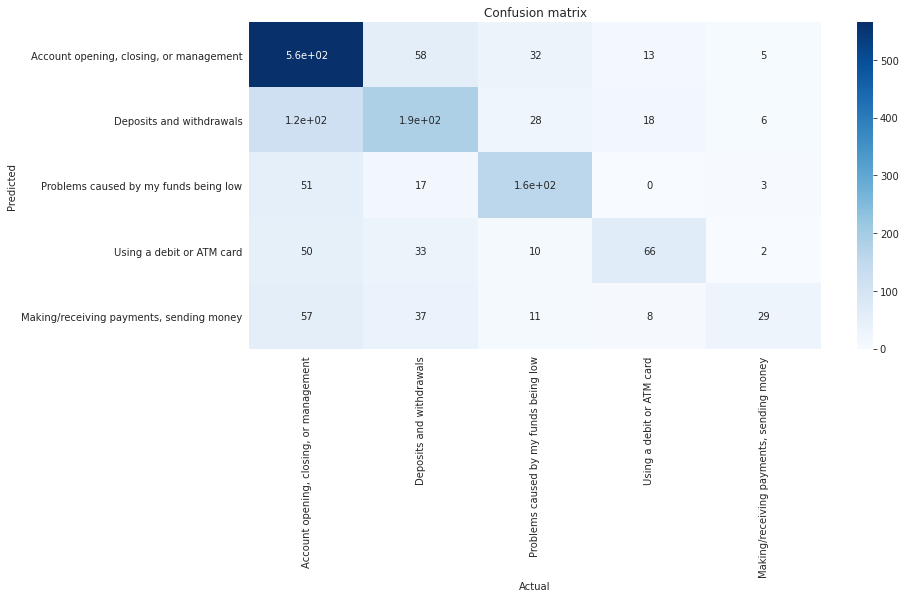

In [ ]:
acc = accuracy_score(labels_test, rfc_pred)
f1 = f1_score(labels_test, rfc_pred, average='macro')
print(classification_report(labels_test,rfc_pred))

aux_df = df[['problema', 'classe']].drop_duplicates().sort_values('classe')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=aux_df['problema'].values,
            yticklabels=aux_df['problema'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (results['mean_test_F1'][best_scorer_index], results['mean_test_Accuracy'][best_scorer_index]))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

Cross-validation scores
F1: 0.543 - Accuracy: 0.650 
---------------------------
Test scores
F1: 0.554 - Accuracy: 0.643 


In [ ]:
d = {
     'Estimator': 'Random Forest',
     'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

In [ ]:
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.543, 0.65)","(0.554, 0.643)"


## 4.2. Support Vector Machine



### 4.2.1. Ajuste de Parâmetros

Vamos ajustar os seguintes parâmetros:

* C: Tolerância a erros de classificação;
* kernel: Especifica o Kernel;
* gamma: coeficiente do kernel (aplicável para os kernels ‘rbf’, ‘poly’ e ‘sigmoid’);
* degree: quando o kernel for polinomial, determina o grau.

In [ ]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [ ]:
# Randomized Search Cross Validation

# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=5,
                                   scoring=score_metrics,
                                   refit='F1',
                                   cv=3,
                                   verbose=1,
                                   random_state=8,
                                   n_jobs =2)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  4.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=8,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=5, n_jobs=2,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   pre_dispatch='2*n_jobs', random_state

In [ ]:
print("Os melhores hiperparâmetros encontrados com o Radom Search são:")
print(random_search.best_params_)
print("")
print("A macro F1 obtida com esses hiperparâmetros é:")
print(random_search.best_score_)

Os melhores hiperparâmetros encontrados com o Radom Search são:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

A macro F1 obtida com esses hiperparâmetros é:
0.5106940603105031


In [ ]:
results = random_search.cv_results_

In [ ]:
best_svm = random_search.best_estimator_
best_svm

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma=10, kernel='poly',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

### 4.2.2. Treinamento e avaliação do modelo

In [ ]:
best_scorer_index = np.nonzero(results['rank_test_F1'] == 1)[0][0]
best_scorer_index

3

In [ ]:
best_svm.fit(features_train, labels_train)
svm_pred = best_svm.predict(features_test)

In [ ]:
acc = accuracy_score(labels_test, svm_pred)
f1 = f1_score(labels_test, svm_pred, average='macro')
print(classification_report(labels_test,svm_pred))

              precision    recall  f1-score   support

           1       0.65      0.83      0.73       673
           2       0.54      0.42      0.47       358
           3       0.60      0.57      0.59       230
           4       0.58      0.37      0.45       161
           5       0.54      0.36      0.43       142

    accuracy                           0.61      1564
   macro avg       0.58      0.51      0.53      1564
weighted avg       0.60      0.61      0.59      1564



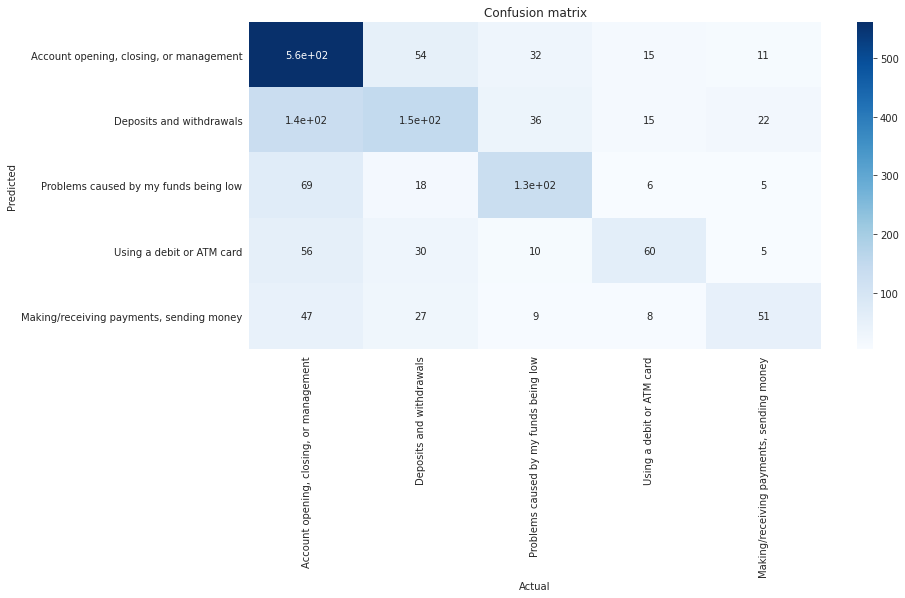

In [ ]:
aux_df = df[['problema', 'classe']].drop_duplicates().sort_values('classe')
conf_matrix = confusion_matrix(labels_test, svm_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=aux_df['problema'].values,
            yticklabels=aux_df['problema'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (results['mean_test_F1'][best_scorer_index], results['mean_test_Accuracy'][best_scorer_index]))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

Cross-validation scores
F1: 0.511 - Accuracy: 0.606 
---------------------------
Test scores
F1: 0.534 - Accuracy: 0.610 


In [ ]:
['Estimator', 'Cross-validation Scores', 'Test Set Scores']

d = {
     'Estimator': 'SVM',
     'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

In [ ]:
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.539, 0.644)","(0.558, 0.645)"
1,SVM,"(0.511, 0.606)","(0.534, 0.61)"


## 4.3. Multinomial Naïve Bayes


### 4.3.1. Ajuste de Parâmetros


In [ ]:
mnbc = MultinomialNB()
mnbc

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Aqui vamos utilizar o valor padrão de Alpha (indicando que deseja-se utilizar a suavização de Laplace)

### 4.3.2. Treinamento e avaliação do modelo

In [ ]:
scores = cross_validate(mnbc, features_train, labels_train, scoring=score_metrics, cv=3, return_train_score=True)

In [ ]:
print(scores.keys())
print(scores['test_F1'])

dict_keys(['fit_time', 'score_time', 'test_F1', 'train_F1', 'test_Accuracy', 'train_Accuracy'])
[0.36984984 0.36705949 0.35905912]


              precision    recall  f1-score   support

           1       0.53      0.95      0.68       673
           2       0.57      0.30      0.39       358
           3       0.75      0.56      0.64       230
           4       0.85      0.07      0.13       161
           5       0.00      0.00      0.00       142

    accuracy                           0.56      1564
   macro avg       0.54      0.37      0.37      1564
weighted avg       0.56      0.56      0.49      1564



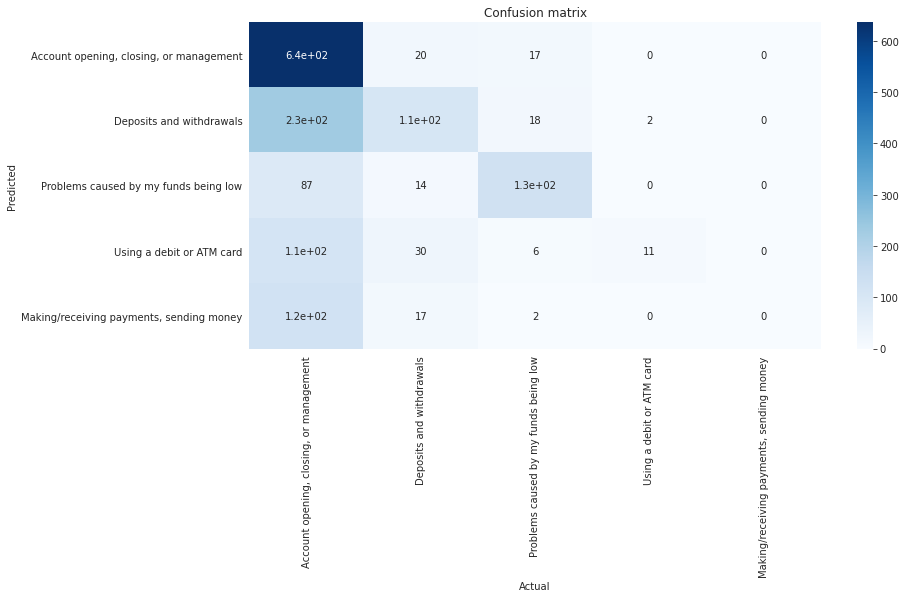

In [ ]:
mnbc.fit(features_train, labels_train)
mnbc_pred = mnbc.predict(features_test)

acc = accuracy_score(labels_test, mnbc_pred)
f1 = f1_score(labels_test, mnbc_pred, average='macro')
print(classification_report(labels_test,mnbc_pred))

aux_df = df[['problema', 'classe']].drop_duplicates().sort_values('classe')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=aux_df['problema'].values,
            yticklabels=aux_df['problema'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (round(np.mean(scores['test_F1']),3), round(np.mean(scores['test_Accuracy']),3)))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

Cross-validation scores
F1: 0.365 - Accuracy: 0.567 
---------------------------
Test scores
F1: 0.368 - Accuracy: 0.564 


In [ ]:
d = {
     'Estimator': 'MultinomialNB',
     'Cross-validation Scores': (round(np.mean(scores['test_F1']),3), round(np.mean(scores['test_Accuracy']),3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

In [ ]:
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.539, 0.644)","(0.558, 0.645)"
1,SVM,"(0.511, 0.606)","(0.534, 0.61)"
2,MultinomialNB,"(0.365, 0.567)","(0.368, 0.564)"


# 5 - Análise do modelo

In [ ]:
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.539, 0.644)","(0.558, 0.645)"
1,SVM,"(0.511, 0.606)","(0.534, 0.61)"
2,MultinomialNB,"(0.365, 0.567)","(0.368, 0.564)"


Vamos escolher o modelo gerado com o algoritmo Random Forest por ter alcançado os melhores indicadores.

Vamos agora analisar os erros de classificação para entender esse comportamento.

In [ ]:
predictions = best_rfc.predict(features_test)

Vamos criar o dataframe do conjunto de testes com as categorias reais e previstas:

In [ ]:
# Category mapping dictionary
classes = {'Account opening, closing, or management':1,
           'Deposits and withdrawals':2,
           'Problems caused by my funds being low':3,
           'Using a debit or ATM card':4,
           'Making/receiving payments, sending money':5}

problemas = {1:'Account opening, closing, or management',
             2:'Deposits and withdrawals',
             3:'Problems caused by my funds being low',
             4:'Using a debit or ATM card',
             5:'Making/receiving payments, sending money'}

# Indexes of the test set
index_X_test = X_test.index

# We get them from the original df
df_test = df.loc[index_X_test]

# Add the predictions
df_test['classe_prevista'] = predictions

# Clean columns
df_test = df_test[['narrativa', 'problema', 'classe', 'classe_prevista']]

# # Decode
df_test['problema_previsto'] = df_test['classe_prevista']
df_test = df_test.replace({'problema_previsto':problemas})

# # Clean columns again
df_test = df_test[['narrativa', 'problema', 'classe', 'classe_prevista','problema_previsto']]

In [ ]:
df_test.head()

,narrativa,problema,classe,classe_prevista,problema_previsto
5485,BancorpSouth changes the order that debits pos...,Problems caused by my funds being low,3,3,Problems caused by my funds being low
9909,I have been trying to get a person bank accoun...,"Account opening, closing, or management",1,1,"Account opening, closing, or management"
400,I was overdrawn by {$150.00} in one Bank of Am...,Problems caused by my funds being low,3,1,"Account opening, closing, or management"
3378,"Paypal/ XXXX, signed me up for paypal credit w...","Making/receiving payments, sending money",5,1,"Account opening, closing, or management"
7673,I have CDs with Ally Bank which were expiring ...,Deposits and withdrawals,2,1,"Account opening, closing, or management"


Vamos pegar os artigos classificados incorretamente:

In [ ]:
condition = (df_test['classe'] != df_test['classe_prevista'])

df_misclassified = df_test[condition]

df_misclassified.head(5)

,narrativa,problema,classe,classe_prevista,problema_previsto
400,I was overdrawn by {$150.00} in one Bank of Am...,Problems caused by my funds being low,3,1,"Account opening, closing, or management"
3378,"Paypal/ XXXX, signed me up for paypal credit w...","Making/receiving payments, sending money",5,1,"Account opening, closing, or management"
7673,I have CDs with Ally Bank which were expiring ...,Deposits and withdrawals,2,1,"Account opening, closing, or management"
6598,On XXXX/XXXX/2016 I visited navy federal to se...,Deposits and withdrawals,2,1,"Account opening, closing, or management"
6325,I have asked Shellpoint to forward my Mortgage...,"Account opening, closing, or management",1,5,"Making/receiving payments, sending money"


Vamos pegar uma amostra de 3 artigos. Vamos definir uma função para tornar esse processo mais rápido:

In [ ]:
def output_article(row_article):
    print('Actual Category: %s' %(row_article['problema']))
    print('Predicted Category: %s' %(row_article['problema_previsto']))
    print('-------------------------------------------')
    print('Text: ')
    print('%s' %(row_article['narrativa']))

Selecionar três índices aleatoriamente:

In [ ]:
import random

random.seed(1)
list_samples = random.sample(list(df_misclassified.index), 3)
list_samples

[1636, 5177, 4790]

**Texto 1**

In [ ]:
output_article(df_misclassified.loc[list_samples[0]])

Actual Category: Making/receiving payments, sending money
Predicted Category: Deposits and withdrawals
-------------------------------------------
Text: 
I own a small business in XXXX XXXX, as a regular practice I have to send checks back to my clients for refunds. On XXXX XXXX, 2015 I mailed out a check to one of my XXXX to XXXX for {$770.00} dollars. After 15 days my client called and ask me about the refund because he never received the check. I went to the branch where I have the account located in XXXX XXXX and XXXX XXXX XXXX XXXX, and the check appear deposit and paid to the account number XXXX in XXXX XXXX My client has not business in XXXX, he lives in XXXX XXXX I dispute the check with the Capital One Bank immediately but not case number was given to me and I asked for it, few days again I spoke to the branch manager who told me that the case was with the Fraud investigation unit but she can not give a phone number to follow up. After 2 months I have not received any answer f

Avaliar

**Texto 2**

In [ ]:
output_article(df_misclassified.loc[list_samples[1]])

Actual Category: Problems caused by my funds being low
Predicted Category: Account opening, closing, or management
-------------------------------------------
Text: 
Suntrust Bank has duplicate reports, reflecting negative history. 
XXXX XXXX XXXX was mortgage service r and collected payments until XXXX 2014 which were on time along with ChXXXX arrears current status. 
Mortgage hard inquiry most recent not authorized to be done. 



Avaliar

In [ ]:
output_article(df_misclassified.loc[list_samples[2]])

Actual Category: Account opening, closing, or management
Predicted Category: Problems caused by my funds being low
-------------------------------------------
Text: 
In 2014 I started an account with US Bank after being talked into it by a coworker, who said they were great. I started a checking and savings account with no bounce protection because I did n't want to spend money I did n't have in my account. However I was told by their employee about changing my protection to not have fees on the account by the mobile banking app. Just in case I ever was near over drafting, I went ahead and changed the overdraft protection in XX/XX/XXXX thinking I would be better protected but it changed my account type so much I got hit with XXXX {$36.00} charges. When calling customer service I was told I would need to speak to the rep that started my service ( who no longer works there ) and I told them this and they did n't care. I told my same story to a XXXX in management and she said I would have

Avaliar